# 泰坦尼克号生存预测（上）——LR

作者：maxmon

官网：[www.abuquant.com](http://www.abuquant.com)

阿布量化版权所有 未经允许 禁止转载

> TAG: Machine Learning, 机器学习, LR, 逻辑回归, 逻辑分类, 泰坦尼克号, Logistic Regression, Logistic Classification, 线性模型

____

LR是一种线性模型

- LR：逻辑分类模型(Logistic Classification)，用于分类预测
- LR：线性回归模型(Linear Regression)，用于回归预测

## 环境

- [Anaconda主页](https://www.anaconda.com/download/) 下载终端运行Anaconda脚本
- [abupy量化系统主页](https://github.com/bbfamily/abu) 终端运行`pip install abupy`
- [泰坦尼克号数据集](https://github.com/maxmon/abu_ml/tree/master/ipython/data/titanic)下载数据集，为了实验方便，我们只选择train.csv作为全部实验数据集

## 泰坦尼克号生存预测

> 泰坦尼克号的沉没是历史上最臭名昭著的沉船之一。 1912年4月15日，在它的首航中，泰坦尼克号在与冰山撞击后沉没，在2224名乘客和船员中丧生1502人。 这一耸人听闻的悲剧震撼了国际社会，并为船舶制定了更好的安全条例。海难导致这种生命损失的原因之一是乘客和船员没有足够的救生艇。 虽然有一些运气涉及幸存下沉，一些人群比其他人更可能生存，如妇女，儿童和上层阶级。
    
![](img/1/4/titanic.jpg)

在这个例子中，我们的任务是完成对什么样的人可能生存的分析，应用机器学习的工具来预测哪些乘客幸免于悲剧。

#### 任务描述：

- 样本数：891名乘客信息（小数据集）
- 原始特征数：11
    - PassengerId：乘客id
    - Pclass：几等舱(1 = 一等舱，2 = 二等舱，3 = 三等舱)
    - Name：名字
    - Sex：性别
    - Age：年龄
    - SibSp：兄弟姐妹/配偶的数量
    - Parch：父母/孩子的数量
    - Ticket：机票号码
    - Fare：票价
    - Cabin：客舱
    - Embarked：登船的港口（C = 瑟堡，Q = 皇后镇，S = 南安普顿）
- 目标：预测Survived（1 = 生存，0 = 死亡）

## 课题A：理解LR

**把每个特征对分类结果的“作用”加起来——这就是线性模型**。

LR可以作为逻辑分类(Logistic Classification)或者线性回归(Linear Regression)的简称。

逻辑分类（Logistic Classification）是一种线性模型，模型对特征数据的核心表达式为：$y = w \cdot x + b$。需要说明的是有些资料中逻辑分类也叫作逻辑回归(Logistic Regression)，但它本身是用作分类问题的。

使用模型分为**模型训练和模型预测**两个环节。工程角度，可以通过输入输出的方式理解模型，模型训练为：

$$\text{数据X + 标签y} \to \text{模型(w, b)}$$

而模型预测可以理解为：

$$\text{数据X + 模型(w, b)} \to \text{标签y}$$

只要是可导的模型表达式，都可以使用梯度下降训练，这里不用再多说。

逻辑分类模型预测一个样本分为三步：

1. 计算线性函数
2. 从分数到概率的转换
3. 从概率到标签的转换

而回归问题预测一个样本时只有第一步。

![](./img/lr_total.jpeg)


也就是说，**很多同一思路设计的模型稍作修改可以生成两种模型，分别用于分类和回归两种问题**。他们的设计区别仅仅在于：

- 模型输出没有作概率映射
- 损失函数的区别
- 评估体系的区别

## 课题B：使用LR

这一实验案例旨在介绍使用LR模型时的一些数据、特征的处理技巧。

### 第一步：观察数据集

下文出于实验方便的目的，我们将忽视数据集的test.csv，直接在train.csv分割训练-测试集，显式观测成绩。

关心的要点有这么几个：

- 采集的样本是否有缺失数据
- 不同类别的样本数量分布是否基本均匀

In [1]:
import pandas as pd # pandas是python的数据格式处理类库

# 加载泰坦尼克号生存预测数据集
data_train = pd.read_csv("../data/titanic/train.csv")
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [2]:
data_train.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


可以看到，样本类别比例549:342，略不均衡，但差距不大。同时注意到“Age”、“Cabin”、“Embarked”维度的数据有缺失，在开始模型训练之前，我们需要处理这一情况。

### 第二步：特征数据预处理

这里要处理特征的输入数据，使其适合模型去训练。

首先，观察并挑选特征。

In [3]:
data_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


“Survived”是生存预测的数据标签。特征“PassengerId”、“Ticket”、“Name”维度下的数据基本是完全随机的，这些特征应该和任务的目标生存预测不相关。

#### 两类特征

剩下的输入特征分为两类：一类是有**数值**意义的数据，如：年龄“Age”、票价“Fare”、兄弟姐妹/配偶的数量“SibSp”、父母/孩子的数量“Parch”；另一类是有**类别**意义的数据，比如几等舱“Pclass”、性别“Sex”、登船港口“Embarked”、客舱“Cabin”，这种特征下的数值是没有数量意义的，如特征“Pclass”（几等舱）下的样本数值：“1”和“3”，并不是表示数量或者长度的3倍关系，而仅仅类别标号。

当两种数据同时流入模型时，模型并不知道哪些是数量意义的数值，哪些是类别意义的数值，所以我们需要把这两类特征需要分开处理一下。

#### 处理数值型数据的缺失

先处理“数值”意义的特征数据，第一个问题是“Age”的数据缺失。补全缺失数据的唯一要点就是：**尽量保持原始信息状态**。处理手段视情况而定，总共这么几种：

- 扔掉缺失数据
- 按某个统计量补全；统计量可以是定值、均值、中位数等
- 拿模型预测缺失值

对于大数据集的小比例缺失，可以直接扔掉这部分数据样本，因为样本充分，信息不会损失多少。但泰坦尼克号数据样本总共891条，而且可以直观的猜到，“年龄”这一特征非常影响样本是否在灾难中存活，，所以我们希望补全这部分信息而不是丢弃。

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


“年龄”特征缺失约20%，**可以通过一些统计图形直观观察数据分布**，如下面拿使用计直方图观察原始数据分布：

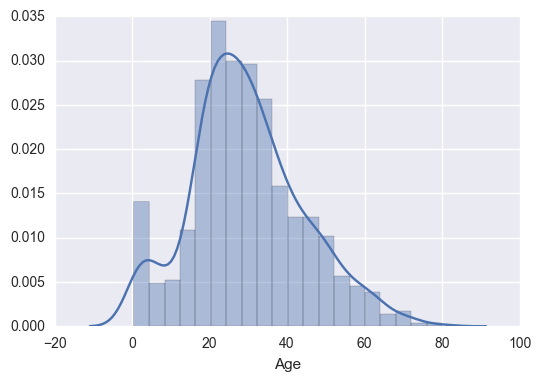

In [13]:
%matplotlib inline
import seaborn as sns # seaborn包含了一系列的统计图形函数

sns.distplot(data_train["Age"].dropna(), kde=True, hist=True)

上图中，直方图的横轴是年龄的数值，每个直方块的宽度(bins)代表在一个年龄范围，如Age：0-5这样。纵轴是归一化以后的数量(即该区域的样本数量除以总数)，直方块就是统计样本落在每个区间的数量比例。

按均值函数填充后，观察分布：

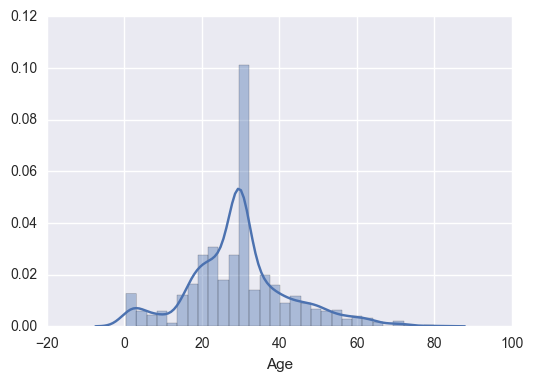

In [14]:
def set_missing_ages(p_df):
    """均值特征填充"""
    p_df.loc[(p_df.Age.isnull()), 'Age'] = data_train.Age.dropna().mean()
    return p_df

data_train = set_missing_ages(data_train)
data_train_fix1 = set_missing_ages(data_train)
sns.distplot(data_train_fix1["Age"], kde=True, hist=True)

我们无视了数据内在的联系，直接用均值补充数据，这种拍脑袋的做法自然不合理，统计的拟合曲线明显变形了。于是，下面取出一些感觉上和“年龄”相关的特征，比如船票、家庭成员数量等，扔进线性回归模型中，通过模型预测年龄看看：

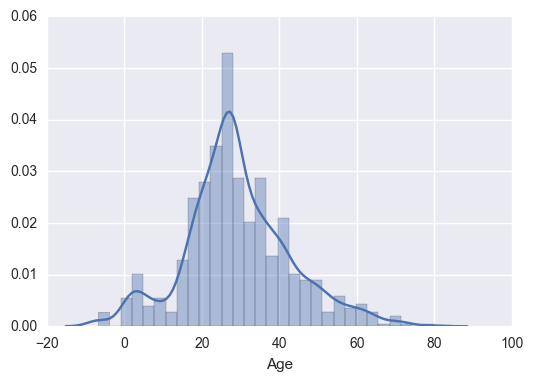

In [16]:
from abupy import AbuML
import sklearn.preprocessing as preprocessing

def set_missing_ages2(p_df):
    """回归模型预测特征填充"""
    age_df = p_df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    # 归一化
    scaler = preprocessing.StandardScaler()
    fare_scale_param = scaler.fit(age_df['Fare'].reshape(-1, 1))
    age_df['Fare_scaled'] = scaler.fit_transform(age_df['Fare'].reshape(-1, 1), fare_scale_param)
    del age_df['Fare']
    # 分割已经数据和待预测数据集
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y_inner = known_age[:, 0]
    x_inner = known_age[:, 1:]
    # 训练
    rfr_inner = AbuML(x_inner, y_inner, age_df.Age.notnull())
    rfr_inner.estimator.polynomial_regression(degree=1)
    reg_inner = rfr_inner.fit()
    # 预测
    predicted_ages = reg_inner.predict(unknown_age[:, 1::])
    p_df.loc[(p_df.Age.isnull()), 'Age'] = predicted_ages
    return p_df

data_train = pd.read_csv('../data/titanic/train.csv')
data_train_fix2 = set_missing_ages2(data_train)
sns.distplot(data_train_fix2["Age"], kde=True, hist=True)

下面直观对比下在最后的模型中，使用不同的数据填充方式造成的成绩对比：

In [16]:
data_train_fix1 = set_cabin_type(data_train_fix1)
train_val(data_train_fix1)

accuracy mean: 0.798073714675


使用 set_missing_ages2 ，回归模型预测填充的模型成绩：

In [17]:
data_train_fix2 = set_cabin_type(data_train_fix2)
train_val(data_train_fix2)

accuracy mean: 0.809183974577


#### 归一化数值数据

对于两类特征数据混杂的问题，我们可以看到，票价“Fare”、年龄“Age”这两个数值特征和其它特征明显不在同一可以比较的尺度上。在使用梯度下降训练模型时，往往希望所有的输入数据在差不多同一尺度上可比较，所以下面归一化这两个维度的数据。

In [5]:
import sklearn.preprocessing as preprocessing

scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(data_train['Age'].reshape(-1, 1))
df['Age_scaled'] = scaler.fit_transform(data_train['Age'].reshape(-1, 1), age_scale_param)

fare_scale_param = scaler.fit(data_train['Fare'].reshape(-1, 1))
df['Fare_scaled'] = scaler.fit_transform(data_train['Fare'].reshape(-1, 1), fare_scale_param)

#### 处理类别意义的特征数据

客舱号“Cabin”的缺失程度太严重了，在整体样本很小，$1-\frac{204}{891} = 77\%$的缺失程度的数据不可能有效恢复。我们的灵感是客舱号信息“Cabin”虽然无法提取，但可以将“有没有在客舱”这一信息作为特征提取出来。

In [6]:
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df
df = set_cabin_type(df)

对于类别意义的特征，数值大小没有任何数量上的意义。就像前面提到的，对于“Pclass”，1和3并不是表示数量关系，而是类别标号。对于类别标号有意义的只有“是”这一类和“不是”这一类。所以，对于所有的类别意义的特征，下面将按类别标号重新建立新的特征，特征的数值只有1和0，标识样本“是”这一类或者“不是”这一类。

In [7]:
dummies_pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
dummies_pclass.head(3)

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0


对于特征“Embarked”，缺失的数据样本只有两条，对于这两条数据，在按特征标签展开时，每个特征标签数值都为0。

In [8]:
dummies_embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies_embarked.loc[61]

Embarked_C    0.0
Embarked_Q    0.0
Embarked_S    0.0
Name: 61, dtype: float64

预处理其它类别数据，把“Sex”的文本换成数字类别标号。

In [9]:
dummies_sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies_sex.head(3)

,Sex_female,Sex_male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0


接下来把处理好的数据维度合并进去，不需要的数据维度扔掉：

In [10]:
df = pd.concat([df, dummies_embarked, dummies_sex, dummies_pclass], axis=1)

# noinspection PyUnresolvedReferences
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

到这里为止，输入数据就预处理好了，看下模型将要用哪些特征。

In [11]:
# 选择哪些特征作为训练特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_df.head(1)

,Survived,SibSp,Parch,Age_scaled,Fare_scaled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,-0.592481,-0.502445,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### 第三步：训练模型

接入模型看看成绩：

In [13]:
from abupy import AbuML

train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_regression()
titanic.cross_val_accuracy_score()

accuracy mean: 0.79919731018


array([ 0.77777778,  0.78888889,  0.7752809 ,  0.82022472,  0.78651685,
        0.7752809 ,  0.78651685,  0.79775281,  0.83146067,  0.85227273])

## 课题C：优化LR

### 构造非线性特征

我们希望逻辑分类模型可以做得更好。前面提到，逻辑分类是一个”线性模型“，所谓线性模型就是把特征对分类结果的作用加起来，也就是说线性模型能表示类似于$y=x_1+x_2$关系的表达式（$y$表示分类结果，$x_1$、$x_2$表示特征对分类的作用），但线性模型无法表示一些非线性的关系如$y=x_1{\cdot}{x_2}$。所以我们打算**人工构造一些新的特征，弥补线性模型对非线性表达式表达能力的不足**。

特征的非线性的表达式可以分为两类：

1. 用于表达“数值特征”本身的非线性因素
2. 用于表达特征与特征之间存在非线性关联，并且这种关联关系对分类结果有帮助

第一种情况是说特征对目标类别的作用不是线性关系。比如两个样本的特征数值是$1$和$3$，对应的，这个特征对分类产生的作用其实是$1^2$和$3^2$，或者$ln1$和$ln3$。

就像年纪轻的可能比年纪大的在灾难中更容易存活，但太年幼的又可能不如年轻的易存活。年龄数值的线性数量描述并不能直接描述出特征“年龄”对样本是否能在灾难中存活产生的影响。

对于第一种，仅适用于数值特征，对应的构造特征的方式有两种：**函数化和离散化**。函数构造指的是将原有数值的函数输出作为特征，比如觉得特征没有那么强的作用力，可以将特征数据的log值作为特征；数据离散化是指将连续的数值划分成一个个区间，以数值是否在区间内作为特征。

举个简单的实现例子，对于特征“Age”，可以构造平方特征，也可以是否满足$Age<=10$这一条件划分区间构造出新特征。

In [14]:
# 划分区间
df['Child'] = (data_train['Age'] <= 10).astype(int)
# 平方
df['Age*Age'] = data_train['Age'] * data_train['Age']
# 归一化
age2_scale_param = scaler.fit(df['Age*Age'].reshape(-1, 1))
df['Age*Age_scaled'] = scaler.fit_transform(df['Age*Age'].reshape(-1, 1), age2_scale_param)

接着尝试构造新特征表达特征与特征之间的非线性关联，源自**多项式**的思路。在理论上，变量的无穷多项式$(x_1 + x_2)^n$可以表示$x_1$和$x_2$的所有关系表达式，n越小表示的是$x_1$和$x_2$的越主要的关系表达式。

比如：我们觉得“Pclass”数值越大越不容易生存下来，头等舱的遇害人员应该比三等舱的更可能被照顾；同时年龄越大的人也越不容易生存下来，越小的越可能被照顾，会不会这两个特征之间也有一些关联，并且这种关联对生存预测有指导意义呢？

我们可以构造一个新的交叉特征“Age * Class”，加入模型中，也可以构造更复杂的$(Age + Class)^n$，从平方到高次方。

In [15]:
df['Age*Class'] = data_train['Age'] * data_train['Pclass']
# 归一化
age_class_scale_param = scaler.fit(df['Age*Class'].reshape(-1, 1))
df['Age*Class_scaled'] = scaler.fit_transform(df['Age*Class'].reshape(-1, 1), age_class_scale_param)

看下模型现在用的特征：

In [16]:
# filter加入新增的特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*|Child|Age\*Class_.*')
train_df.head(1)

,Survived,SibSp,Parch,Age_scaled,Fare_scaled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Child,Age*Age_scaled,Age*Class_scaled
0,0,1,0,-0.592481,-0.502445,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,-0.636573,0.031376


新加入的这些特征，对模型的表现是否有提升呢？

In [17]:
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_regression()
titanic.cross_val_accuracy_score()

accuracy mean: 0.804752298264


array([ 0.8       ,  0.8       ,  0.78651685,  0.84269663,  0.79775281,
        0.76404494,  0.79775281,  0.78651685,  0.84269663,  0.82954545])

### 评估特征作用

一般而言，机器学习中看一个新特征是否发挥作用，**最常用的方法就是加进去看模型成绩是否提升**。对于LR也可以直接观察模型给特征分配的权重，看特征发挥作用的大小：

In [18]:
titanic.importances_coef_pd()

********************LogisticRegression********************


,coef,columns
0,[-0.410298136384],SibSp
1,[-0.173336882199],Parch
2,[-0.208459115049],Age_scaled
3,[0.165577117349],Fare_scaled
4,[0.0],Embarked_C
5,[0.0],Embarked_Q
6,[-0.405822408349],Embarked_S
7,[1.99640288087],Sex_female
8,[-0.715926302128],Sex_male
9,[0.663404977168],Pclass_1


可以看到，在训练好的模型中，特征“Child”有效发挥了作用，而“Age\*Class”、“Age\*Age”没有什么用。

### 构造特征的数学意义

通过人工构造非线性特征，可以弥补线性模型表达能力的不足。这一手段之所以能够生效，背后的原因是：**低维的非线性关系可以在高维空间线性展开**。

解释这一观点，让我想起霍金先生的巨著《时间简史》中提及的一个例子：“这正如同看一架在非常多山的地面上空飞行的飞机。虽然它沿着三维空间的直线飞，在二维的地面上它的影子却是沿着一条弯曲的路径。——飞机影子的运动轨迹在二维地表上看到的是一条非线性的曲线，起伏不定，很难用函数表示；但在三维空间中，其运动轨迹仅仅是一条笔直的直线而已，一个简单的线性函数就可以说明。也就是说在二维空间中看到的复杂表达式，当增加一个维度，其表达式可能就变得非常简单了。

![](img/1/4/plane_f_2.png)

同样的道理，我们可以增加新的特征维度，让分类任务背后的数学表达式变得更简单，让分类模型更容易挖掘出信息——这正是构造新特征有意义的地方：**增加特征维度，构造出模型表达不出来的内在表达式**。对于逻辑分类模型而言，就是通过增加新的非线性特征，完成特征维度的扩展，构造出模型表达不出的非线性的内在关系。

逻辑分类因为是线性模型，原型简单，所以有着训练速度快、易分布式部署等特点。现在业界对逻辑分类仍然有着广泛的应用，尤其适合那些数据海量、特征高维并且稀疏的应用场景。比如在一些涉及海量用户的个性化推荐任务中，海量数据上，把每个用户ID作为一个特征，使用逻辑分类就可以快速有效地完成任务目标。

## 小结

- 线性模型是把每个特征数据按权重加起来，描述特征对分类结果的影响
- 预处理数据
    - 预处理数值数据
    - 预处理类别数据
- 新特征可以增加特征维度，构造出模型表达不出来的内在表达式